# **[作業]電商如何以A/B Test 驗證新網頁設計有效**
## **Can eCommerce UX change boost the conversion rate from 0.13 to 0.15?**
知識點:

*   effect size
*   sample size for A/B test 
*   type I error = 0.05 and Power= 0.8
*   z-score, confidence interval

參考：[A/B testing: A step-by-step guide in Python](https://medium.com/@RenatoFillinich/ab-testing-with-python-e5964dd66143) by Renato Fillinich @ medium.com

數據 : ab_data.csv from Kaggle

# **[作業目標]**

1.   了解 Binomial 分布，以及用常態分布求統計解的方法
2.   判讀A/B Test 結果

# **[作業重點]**



1.   如何決定最小樣本數
2.   如何以 Z 值，p-Value和信賴區間(Confidence Interval)判斷A/B結果是否顯著

In [1]:
# Packages imports
 
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
#plt.style.use('seaborn-whitegrid')
#font = {'family' : 'Helvetica',
#        'weight' : 'bold',
#        'size'   : 14}

#mpl.rc('font', **font)

#求樣本大小
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power( effect_size, 
                                               power=0.8, 
                                               alpha=0.05, 
                                               ratio=1 
                                             )         # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


In [2]:
#展示實驗資料

df = pd.read_csv( 'ab_data.csv' )
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
# To make sure all the control group are seeing the old page and viceversa
# 用 crosstab 將 landing_page 當作 column，group 當作 row

print( 'Shape of Data = ', df.shape )
pd.crosstab( df['group'], df['landing_page'] )

Shape of Data =  (294478, 5)


landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [5]:
# 偵測重複出現使用者
session_counts = df['user_id'].value_counts( ascending=False )
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [6]:
# 除去重複出現使用者
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print( f'The updated dataset now has {df.shape[0]} entries' )

The updated dataset now has 286690 entries


In [7]:
# 選取 控制組和實驗組各半 4720 * 2 = 9440
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [8]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [9]:
# 確認 ab_test 控制組實驗組各半
ab_test['group'].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

In [10]:
# 計算轉換率(conversion rate)、平均值，標準差，標準誤
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


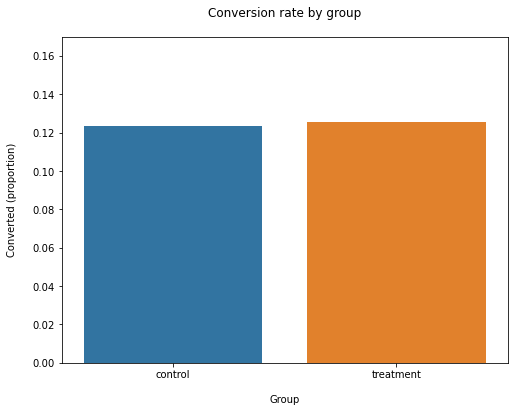

In [11]:
# 繪出 conversion rate 棒狀圖
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [12]:
# 以函數計算 z_stat, pval, confidence interval
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

# 判讀統計結果
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


# 作業：判讀程式最後統計結果，A/B test 是否顯著

z statistic: -0.34

p-value: 0.732

ci 95% for control group: [0.114, 0.133]

ci 95% for treatment group: [0.116, 0.135]

### Ans: 不顯著，因為 $\text{p-value} = 0.732 > 0.05$。

# 作業：試以(0.12, 0.11)計算結果是否顯著


In [13]:
# 求樣本大小
effect_size = sms.proportion_effectsize(0.12, 0.11)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power( effect_size, 
                                               power=0.8, 
                                               alpha=0.05, 
                                               ratio=1 
                                             )         # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

15970


In [14]:
# 選取 控制組和實驗組各半 15970 * 2 = 31940
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
31935,780954,2017-01-19 07:49:58.295232,treatment,new_page,0
31936,700881,2017-01-13 12:31:37.243352,treatment,new_page,0
31937,829626,2017-01-14 09:07:57.784950,treatment,new_page,0
31938,773197,2017-01-05 00:23:56.177295,treatment,new_page,0


In [15]:
# 以函數計算 z_stat, pval, confidence interval

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.07
p-value: 0.945
ci 95% for control group: [0.116, 0.126]
ci 95% for treatment group: [0.116, 0.126]


### Ans: 不顯著，因為 $\text{p-value} = 0.945 > 0.05$。

# 作業：樣本數是以那些模組/函數算的

### Ans: statsmodels.stats.api 及 math